In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cvp
from CSSS import CSSS
import time 
%matplotlib inline

Import the data and drop rows with NAN.

In [2]:
df=pd.read_csv('input_data.csv')
df=df.dropna()

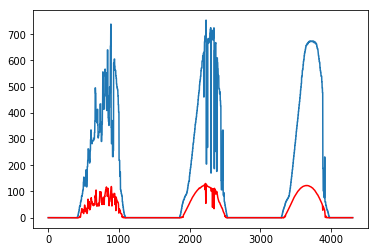

In [3]:
### Look at the solar proxies
plt.plot(df['Irradiance'])
plt.plot(df['IrradianceProxy'],'-r')

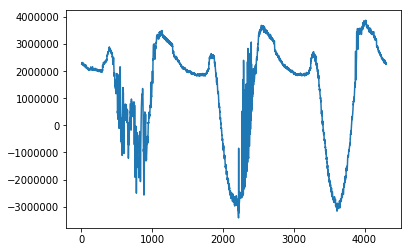

In [4]:
### Look at the total load shape
plt.plot(df['Real_Power_Total'])

In [5]:
# Feeder-level Solar Disagg Using the New Class
N=len(df)
CSSS_solar = CSSS(np.array(df['Real_Power_Total']))  ## Instantiate model with aggregate signal, Y
CSSS_solar.addSource(np.vstack((np.ones((1,N)),np.array(df['Reactive_Power_Total']))).transpose(), alpha = 1, name = 'Load',costFunction='l2')  ## Add a model for Load:  Q + intercept term as regressor
CSSS_solar.addSource(np.array(df['IrradianceProxy']), alpha = 1, name = 'Solar',costFunction='l2') ## Add a model for Solar: Irradiance Proxy Only as regressor.

## Constrain Solar to be <= 0 . 
CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'] <= 0 )
## Constrain Load to be >=0
CSSS_solar.addConstraint(CSSS_solar.models['Load']['source'] >= 0 )

start=time.time()
a=CSSS_solar.constructSolve()
print("It took {} seconds in centralized CSSS".format(time.time()-start))
    

No regularization
No regularization
It took 4.9509999752 seconds in centralized CSSS


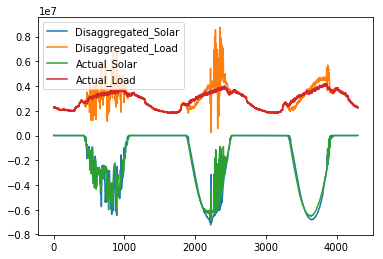

In [6]:
plt.plot(CSSS_solar.models['Solar']['source'].value, label = 'Disaggregated_Solar')
plt.plot(CSSS_solar.models['Load']['source'].value, label = 'Disaggregated_Load')

plt.plot(-1*df['Real_Power_PV'], label = 'Actual_Solar')
plt.plot(df['Real_Power_Total']+df['Real_Power_PV'], label = 'Actual_Load')

plt.legend()
plt.show()